In [58]:
from PIL import Image
from tensorflow.keras.utils import save_img, load_img, img_to_array, array_to_img

In [11]:
test_image = '../raw_data/hilma_study/hilma_original/11110032.jpg'
''

100%|██████████████████████████████████████| 132/132 [00:00<00:00, 15214.71it/s]

DALL·E 2022-07-26 16.32.17 - By Hilma af Klint.png
DALL·E 2022-07-26 17.24.21 - By Hilma af Klint.png
DALL·E 2022-07-26 17.23.39 - By Hilma af Klint.png
DALL·E 2022-07-26 16.32.18 - By Hilma af Klint.png
DALL·E 2022-07-26 17.13.12 - By Hilma af Klint.png
DALL·E 2022-07-26 17.01.35 - By Hilma af Klint.png
DALL·E 2022-07-26 17.17.04 - By Hilma af Klint.png
DALL·E 2022-07-26 17.05.30 - By Hilma af Klint.png
DALL·E 2022-07-26 17.21.56 - By Hilma af Klint.png
DALL·E 2022-07-26 15.54.43 - By Hilma af Klint.png
DALL·E 2022-07-26 17.16.54 - By Hilma af Klint.png
DALL·E 2022-07-26 16.36.01 - By Hilma af Klint.png
DALL·E 2022-07-26 16.38.03 - By Hilma af Klint.png
DALL·E 2022-07-26 17.17.44 - By Hilma af Klint.png
DALL·E 2022-07-26 17.04.20 - By Hilma af Klint.png
DALL·E 2022-07-26 17.03.49 - By Hilma af Klint.png
DALL·E 2022-07-26 17.03.20 - By Hilma af Klint.png
DALL·E 2022-07-26 17.23.43 - By Hilma af Klint.png
DALL·E 2022-07-26 17.04.55 - By Hilma af Klint.png
DALL·E 2022-07-26 16.37.55 - By

In [59]:
def divide_img_blocks(img, n_blocks=(5, 5)):
    horizontal = np.array_split(img, n_blocks[0])
    split_img_list = []
    for row in horizontal:
        for block in np.array_split(row, n_blocks[1], axis=1):
            split_img_list.append(array_to_img(block))
    return split_img_list #np.array(splitted_img, dtype=object) #.reshape(n_blocks)

tiles = divide_img_blocks(im)

In [60]:
len(tiles)

25

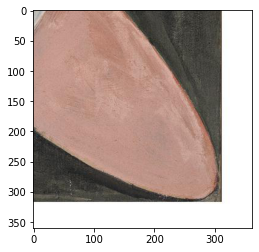

In [62]:
import matplotlib.pyplot as plt

plt.imshow(tiles[24])

In [767]:
import torch
import clip
from torch.nn import functional as F
from sklearn.metrics import mean_squared_error

class TileEncoder:
    
    def __init__(self, model_name):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(model_name, device=device)
        self.mobilnet = init_embedding_model_mobile()
        
    
    def divide_img_tiles(self, img, n_tiles=(5, 5)):
        horizontal = np.array_split(img, n_tiles[0])
        tiles_list = []
        for row in horizontal:
            for tile in np.array_split(row, n_tiles[1], axis=1):
                tiles_list.append(array_to_img(tile))
        return tiles_list

        
    def preprocess_tiles(self, tiles_list):
         return torch.tensor(np.stack([self.preprocess(tile).to(device) for tile in tiles_list]))
        
        
    def encode_images(self, preprocessed_tiles):
        with torch.no_grad():
            image_features = self.model.encode_image(preprocessed_tiles).float()
        return image_features
    
    
    def get_features(self, img):
        
        img_tiles = self.divide_img_tiles(img)

        p_img_tiles = self.preprocess_tiles(img_tiles)

        tiles_features = self.encode_images(p_img_tiles)
        
        return tiles_features, img_tiles
    
    
    def spherical_dist_loss(self, x, y):
        """from github.com/crowsonkb/k-diffusion/sample_clip_guided.py"""
        x = F.normalize(x, dim=-1)
        y = F.normalize(y, dim=-1)
        return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)
    

    def feature_distance(self, pil_img_one, pil_img_two):
    
        features_one, tiles_one = self.get_features(img_to_array(pil_img_one))
        features_two, tiles_two = self.get_features(img_to_array(pil_img_two))
        
        all_tile_combos = list(((x,y) for x in range(len(features_one)) for y in range(len(features_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            sph_dist = spherical_dist_loss(features_one[one_id], features_two[two_id])
            distance_list.append(sph_dist.item())
            
        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]
        #sorted_combos = [{'x_id': combo[0], 'y_id': combo[1], 'dist' : distance} for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])] 

        return sorted_combos, (tiles_one, tiles_two)
    

    def mse_distance(self, pil_img_one, pil_img_two):        
        
        img_tiles_one = self.divide_img_tiles(img_to_array(pil_img_one.resize((50, 50))))
        img_tiles_two = self.divide_img_tiles(img_to_array(pil_img_two.resize((50, 50))))
        
        
#         features_one, tiles_one = self.get_features(img_to_array(pil_img_one))
#         features_two, tiles_two = self.get_features(img_to_array(pil_img_two))
        
        all_tile_combos = list(((x,y) for x in range(len(img_tiles_one)) for y in range(len(img_tiles_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            mse = np.mean((img_to_array(img_tiles_one[one_id]) - img_to_array(img_tiles_two[two_id])) ** 2)
            distance_list.append(mse)
            
        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]
        #sorted_combos = [{'x_id': combo[0], 'y_id': combo[1], 'dist' : distance} for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])] 

        return sorted_combos, (img_tiles_one, img_tiles_two)
    
    def mobilenet_distance(self, pil_img_one, pil_img_two):   
        
        
        
        img_tiles_one = self.divide_img_tiles(img_to_array(pil_img_one))
        img_tiles_two = self.divide_img_tiles(img_to_array(pil_img_two))
        
        features_one = self.mobilenet(img_tiles_one)
        features_two = self.mobilenet(img_tiles_two)
        
        
#         features_one, tiles_one = self.get_features(img_to_array(pil_img_one))
#         features_two, tiles_two = self.get_features(img_to_array(pil_img_two))
        
        all_tile_combos = list(((x,y) for x in range(len(img_tiles_one)) for y in range(len(img_tiles_two))))
        
        distance_list = []
        
        for one_id, two_id in all_tile_combos:
            mse = np.mean(features_one[one_id] - features_two[two_id] ** 2)
            distance_list.append(mse)
            
        sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]
        #sorted_combos = [{'x_id': combo[0], 'y_id': combo[1], 'dist' : distance} for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])] 

        return sorted_combos, (img_tiles_one, img_tiles_two)
    
    
    
#     def colour_distance(self, pil_img_one, pil_img_two):        
        
#         img_tiles_one = self.divide_img_tiles(img_to_array(pil_img_one.resize((50, 50))))
#         img_tiles_two = self.divide_img_tiles(img_to_array(pil_img_two.resize((50, 50))))
        
        
# #         features_one, tiles_one = self.get_features(img_to_array(pil_img_one))
# #         features_two, tiles_two = self.get_features(img_to_array(pil_img_two))
        
#         all_tile_combos = list(((x,y) for x in range(len(img_tiles_one)) for y in range(len(img_tiles_two))))
        
#         distance_list = []
        
#         for one_id, two_id in all_tile_combos:
            
#             mse = np.mean((img_to_array(img_tiles_one[one_id]) - img_to_array(img_tiles_two[two_id])) ** 2)
#             distance_list.append(mse)
            
#         sorted_combos = [(combo[0], combo[1], distance) for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])]
#         #sorted_combos = [{'x_id': combo[0], 'y_id': combo[1], 'dist' : distance} for distance, combo in sorted(zip(distance_list, all_tile_combos), key = lambda pair: pair[0])] 

#         return sorted_combos, (img_tiles_one, img_tiles_two)
        

In [739]:
import tensorflow as tf

def init_embedding_model():
    """ define a pretrained convolutional model from tensorflow to extract features from an array of images"""
    model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
    new_input = model.input
    hidden_layer = model.layers[-1].output
    model_new = tf.keras.Model(new_input, hidden_layer)
    return model_new


def extract_features(model, image_path):
    """ extract features from an image using the pretrained model"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    return features


def get_features(model, image_paths):
    """ extract features from a list of images"""
    features = []
    for image_path in image_paths:
        features.append(extract_features(model, image_path))
    return features

In [768]:
def init_embedding_model_resnet():
    """ define the archtecture of model, with keras.Input
    pretrained convolutional model from tensorflow to extract features from an array of images
    a resizing layer"""
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    resnet.trainable = False
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224, 224, 3)),
        tf.keras.layers.Resizing(224, 224),
        resnet,
        tf.keras.layers.GlobalAveragePooling2D()
    ])
    
    return model
    
def init_embedding_model_mobile():
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.layers.Resizing(224, 224)(x)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
    x = core(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    return model

# image = tf.image.decode_png(tf.io.read_file('file.png'))
# result = model(image)
    



init_embedding_model_resnet

<function __main__.init_embedding_model_resnet()>

In [763]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 tf.cast_9 (TFOpLambda)      (None, None, None, 3)     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228

In [769]:
model = init_embedding_model_mobile()
out = model(np.array([img_to_array(orginal_img)]))
out.shape

TensorShape([1, 1024])

In [770]:
tile_encoder = TileEncoder("ViT-B/32") # "ViT-L/14"

In [771]:
np.array(distance_list).mean()

0.23271745598316193

In [772]:
orginal_img = Image.open('../raw_data/hilma_study/hilma_original/11110045.jpg')

In [773]:
# output_img= Image.open('../raw_data/hilma_study/hilma_dalle/DALL·E 2022-07-26 16.32.17 - By Hilma af Klint.png')

In [774]:
def get_image_paths(folder, limit = None):
    image_paths = []
    for file in os.listdir(f"{folder}"):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.webp') or file.endswith('.png'):
            image_paths.append(f'{folder}/{file}')
    if limit:
        image_paths = image_paths[:min([limit, len(image_paths)])]
    return image_paths

In [775]:
folder = '../raw_data/hilma_study/hilma_dalle'

compare_distances = []
compare_tile_combos = []
tiles_list = []
img_list = []

print("Number of comparisons: ", len(os.listdir(f"{folder}")))

for file_name in tqdm(get_image_paths(folder, limit = 3)):
    #sorted_combos, tiles = tile_encoder.feature_distance(orginal_img, Image.open(f'{folder}/{file}'))
    sorted_combos, tiles = tile_encoder.mse_distance(orginal_img, Image.open(file_name))
    sorted_combos, tiles = tile_encoder.mobilenet_distance(orginal_img, Image.open(file_name))
    
    compare_tile_combos.append(sorted_combos)
    compare_distances.append([results_tup[2] for results_tup in sorted_combos])
    tiles_list.append(tiles)
    img_list.append((orginal_img, Image.open(file_name)))
        
        

Number of comparisons:  132


  0%|                                                     | 0/3 [00:00<?, ?it/s]


AttributeError: 'TileEncoder' object has no attribute 'mobilenet'

In [736]:
len(img_list)

3

In [709]:
closest_ten = np.argsort(np.min(np.array(compare_distances), axis = 1))[-10:] # choose number of comparison images

combos_of_interest = [combos for idx, combos in enumerate(compare_tile_combos) if idx in closest_ten]
tiles_of_interest = [tiles for idx, tiles in enumerate(tiles_list) if idx in closest_ten]
img_of_interest = [img for idx, img in enumerate(img_list) if idx in closest_ten]

In [710]:
# # plot closest tiles
# interest_idx = np.argsort(np.array(compare_distances).reshape(-1))[:10] # choose number of comparison tiles

# img_idx, tile_idx = np.unravel_index(interest_idx, np.array(compare_distances).shape)

# combos_of_interest = [combos for idx, combos in enumerate(compare_tile_combos) if idx in img_idx]
# tiles_of_interest = [tiles for idx, tiles in enumerate(tiles_list) if idx in img_idx]
# img_of_interest = [img for idx, img in enumerate(img_list) if idx in img_idx]

In [711]:
len(combos_of_interest)

10

In [712]:
combos_of_interest[1]
tiles_of_interest[1]
img_of_interest[2]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1357x1800 at 0x1723E6BB0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x16F4FC130>)

In [713]:
# from sklearn.metrics import mean_squared_error, 

# def norm_mse_loss(x, y):
#     x = F.normalize(x, dim=-1)
#     y = F.normalize(y, dim=-1)
#     return mean_squared_error(x, y)

In [714]:
org_match
output_match

{7}

In [719]:
def plot_tiles(org_tiles, output_tiles, org_highlight_idx = None, output_highlight_idx = None):
    fig = plt.figure(constrained_layout=True, figsize = (16, 9))

    subfigs = fig.subfigures(1, 2)

    for subfig, img_tiles, title, highlight_ids in zip(subfigs.flat, 
                                               [org_tiles, output_tiles], 
                                               ['Original', 'AI Generated'], 
                                               [org_highlight_idx, output_highlight_idx]):
        axes = subfig.subplots(5, 5)
        plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=None, wspace=0.03, hspace=0.03)
        for idx, ax in enumerate(axes.flat):
            if idx == 2:
                ax.set_title(f'{title}', fontsize = 24)
            ax.imshow(img_tiles[idx])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            if highlight_ids:
                if type(highlight_ids) == int: 
                    highlight_ids = [highlight_ids] # convert to list if only one number
                if idx in highlight_ids:
                    plt.setp(ax.spines.values(), color='red', linewidth=7)
                
#plot_tiles(tiles_of_interest[0][0], tiles_of_interest[0][1], org_highlight_idx = org_match, output_highlight_idx = output_match)

In [716]:
width = img_tiles[0].size[0]
height = img_tiles[0].size[1]

def get_tile_bbox(tile_idx, width, height):
    
    coords = np.array(np.unravel_index(tile_idx, (5,5)))

    x = coords[1] * height
    y = coords[0] * width

    x_coords = [x, x, x + height -1 , x + height - 1, x] # coords for box, len 5 to wrap around
    y_coords = [y, y + width, y + width, y, y]
                
    return x_coords, y_coords

get_bbox(5, width, height)

#[(615, 820), (410, 410), (205, 205), (820, 615)]

([205, 205, 410, 410, 205], [0, 205, 205, 0, 0])

In [717]:
def plot_comparison(img_one, img_two, org_highlight_idx = None, output_highlight_idx = None):
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 9))

    for ax, img, title, highlight_ids in zip(axes.flat, 
                                               [img_one, img_two], 
                                               ['Original', 'AI Generated'], 
                                               [org_highlight_idx, output_highlight_idx]):
        
        ax.set_title(f'{title}', fontsize = 24)
        ax.imshow(img)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        ax.set_xlim(0, img.size[0])
        ax.set_ylim(img.size[1], 0)
        
        width = img.size[1] // 5
        height = img.size[0] // 5
                
#         width = img_tiles[0].size[0]
#         height = img_tiles[0].size[1] # get tile size, need to get elsewhere
        
        bb_coords = [get_tile_bbox(idx, width, height) for idx in highlight_ids] # 5, 5 from number of splits
        
        
        for box in bb_coords:
            ax.plot(box[0], box[1], c = 'r')

org:  {12}
gen:  {20}
org:  {8}
gen:  {8}
org:  {12}
gen:  {7}
org:  {8}
gen:  {14}
org:  {17}
gen:  {4}
org:  {17}
gen:  {0}
org:  {11}
gen:  {23}
org:  {7}
gen:  {0}
org:  {18}
gen:  {13}
org:  {7}
gen:  {7}


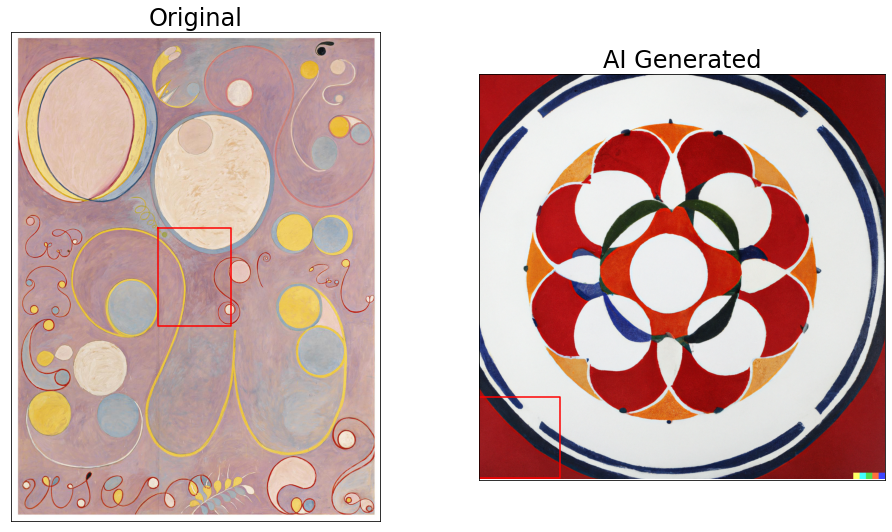

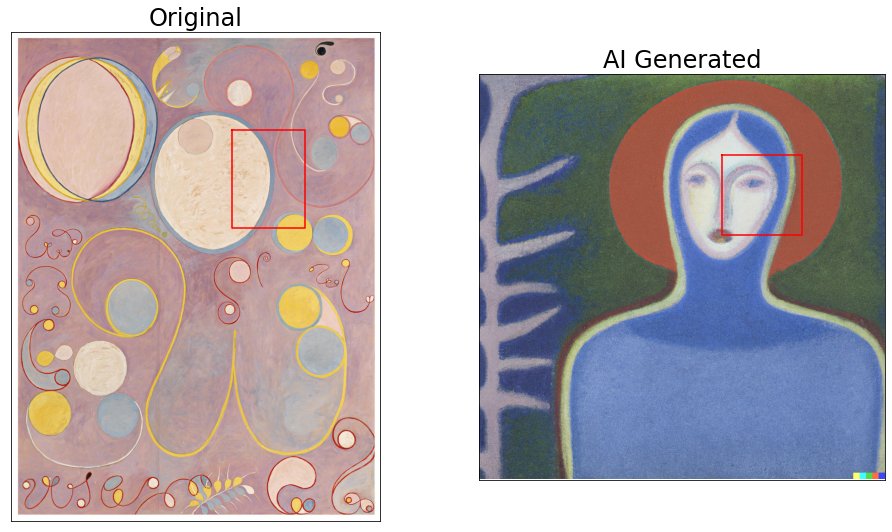

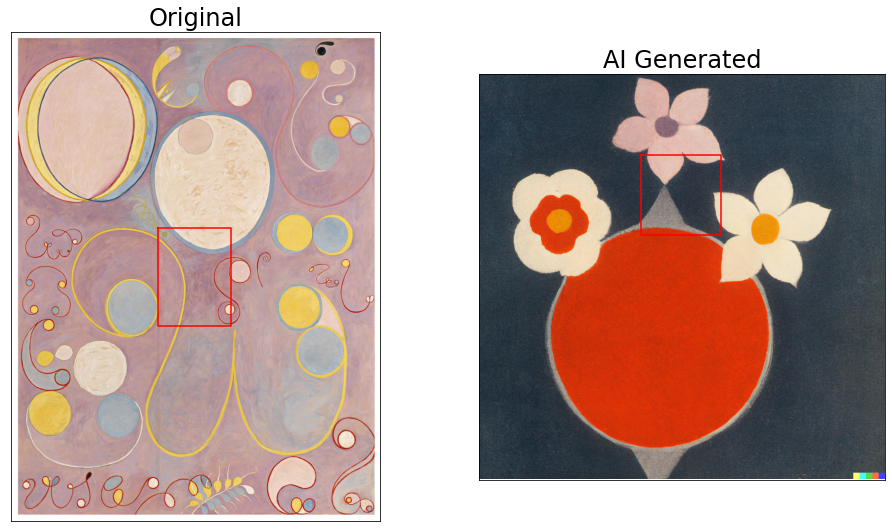

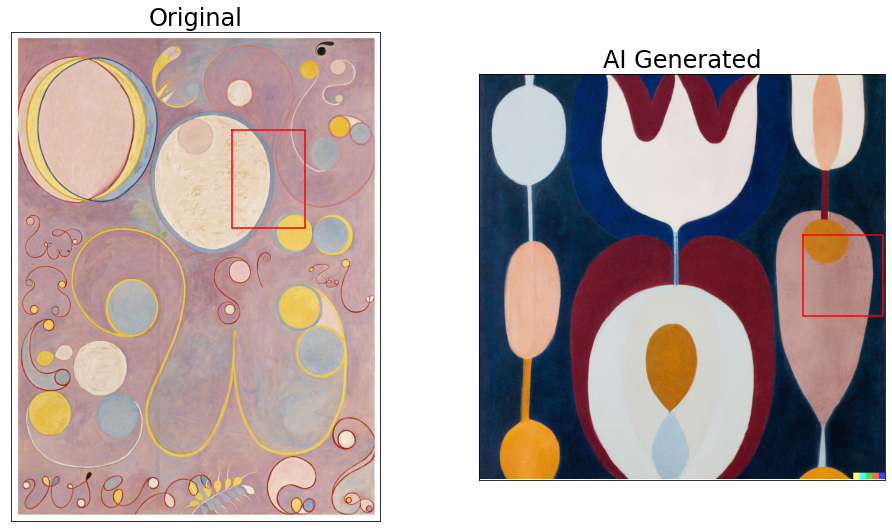

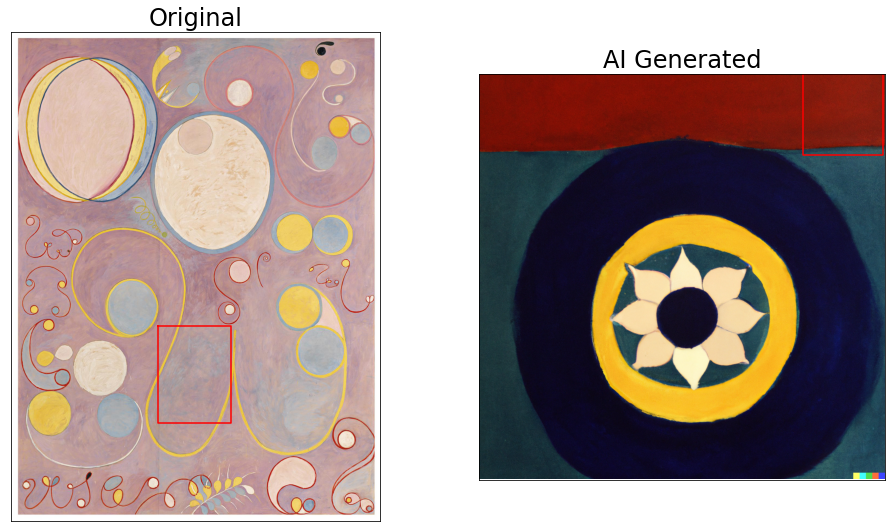

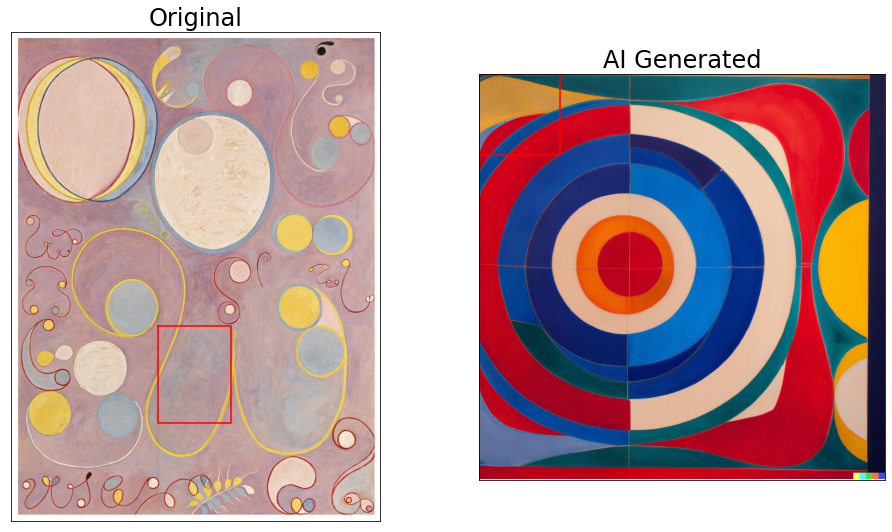

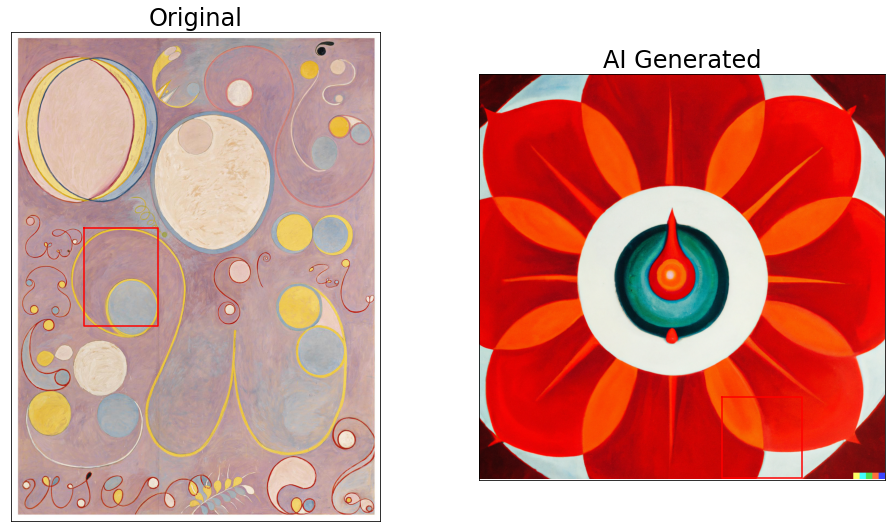

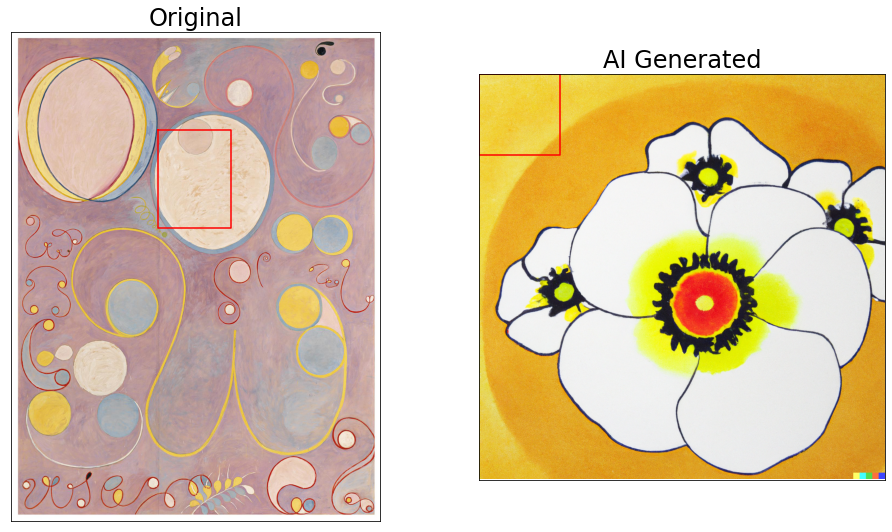

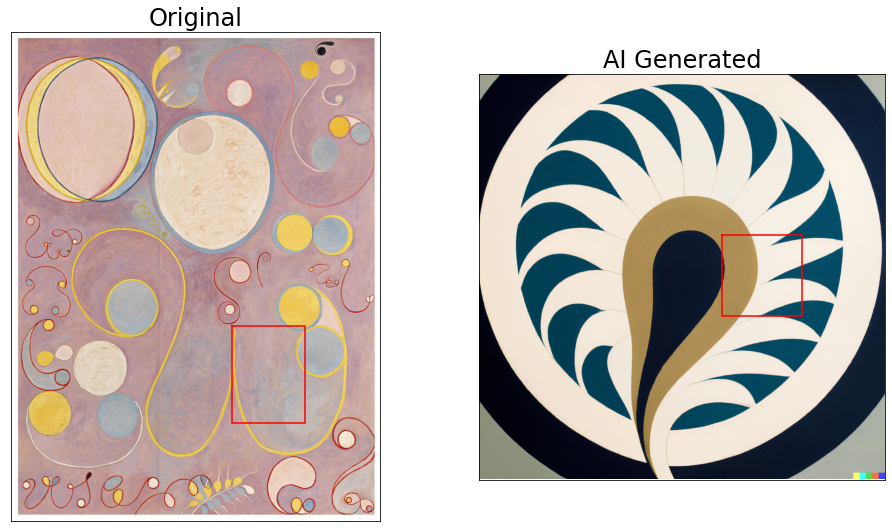

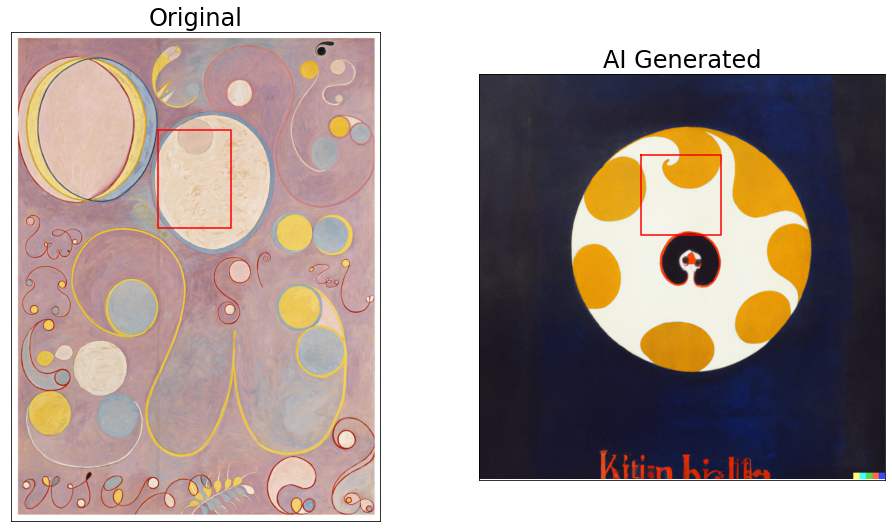

In [718]:
for i in range(10):
    org_match = set([combo[0] for combo in combos_of_interest[i][:1]]) # choose number of bounding boxes
    output_match = set([combo[1] for combo in combos_of_interest[i][:1]])
    print('org: ', org_match)
    print('gen: ', output_match)
    plot_comparison(img_of_interest[i][0], img_of_interest[i][1], org_highlight_idx = org_match, output_highlight_idx = output_match)

In [585]:
1800 // 5

360

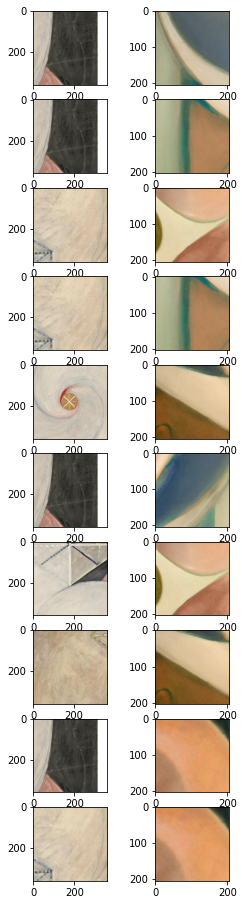

In [559]:
def plot_diff_tiles(org_tiles, output_tiles, combos):
    fig, axes = plt.subplots(10, 2, figsize = (4, 16))

    for idx, combo in enumerate(combos):
        axes[idx, 0].imshow(org_tiles[combo[0]])
        axes[idx, 1].imshow(output_tiles[combo[1]])
        
plot_diff_tiles(org_tiles, output_tiles, sorted_combos[:10])

In [56]:
from hashlib import md5
from tqdm import tqdm
import os

def remove_duplicates_in_folder(folder, destination_folder):
    hash_list = []
    for file in tqdm(os.listdir(f"{folder}")):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.webp') or file.endswith('.png'):
            img = img_to_array(load_img(f'{folder}/{file}'))
            img_hash = md5(img).hexdigest()
            if img_hash not in hash_list:
                hash_list.append(img_hash)
                save_img(f'{destination_folder}/{file}', img)
    old_len = len(os.listdir(f'{folder}'))
    new_len = len(os.listdir(f'{destination_folder}'))
    print(f'Before: {old_len} images')
    print(f'After: {new_len} images')

# !mkdir ../raw_data/hilma_study_nodups

# remove_duplicates_in_folder(folder = '../raw_data/hilma_study', 
#                             destination_folder = '../raw_data/hilma_study_nodups')